In [5]:
import numpy as np
import astropy
import astropy.coordinates as ac
import astropy.units as u
import astropy.io
import astropy.table
import scipy
import pandas as pd
import galstreams
import gcutils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
lono,lato,lonf,latf,ro,rf,width=scipy.genfromtxt(lib_end_points_filen,usecols=(3-1,4-1,5-1,6-1,8-1,9-1,10-1),unpack=True)
name,sname,cootype=scipy.genfromtxt(lib_end_points_filen,usecols=(1-1,2-1,7-1),unpack=True,dtype=str)
azs,lats,azcenter,latcenter=gcutils.get_gc_for_pair(lono[i],lato[i],lonf[i],latf[i],degree=True,step=gcstep,dlat=width[i])


Tracks init by end points
==========================

In [58]:
tpair = astropy.io.ascii.read("lib_by_pair.dat",header_start=4)
#tpair.replace_column('Ro', tpair["Ro"].astype(float))
tpair

Name,ShortName,lono,lato,lonf,latf,frame,Ro,Rf,Width,Reference
str11,str5,float64,float64,float64,float64,str3,float64,float64,float64,str26
Phoenix,Phe,20.0,-57.0,27.0,-45.0,equ,17.5,17.5,0.18,Balbinot2016
Acheron,Ach,230.0,-2.0,259.0,21.0,equ,3.5,3.8,0.9,Grillmair2009
Cocytos,Coc,186.0,-3.0,259.0,20.0,equ,11.0,11.0,0.7,Grillmair2009
Lethe,Let,171.0,18.0,258.0,20.0,equ,13.0,13.0,0.4,Grillmair2009
Styx,Sty,194.0,20.0,259.0,21.0,equ,45.0,45.0,3.3,Grillmair2009
ACS,ACS,126.4,-0.7,133.9,64.2,equ,8.9,8.9,5.0,Grillmair2006
Pal15,Pal15,254.8,-0.12,255.3,-1.47,equ,38.4,38.4,0.0,Myeong2017
Eridanus,Eri,65.98,-21.42,66.4,-20.96,equ,95.0,95.0,0.0,Myeong2017
TucanaIII,Tuc3,-6.3,-59.7,3.2,-59.4,equ,23.0,27.0,0.18,"Shipp2018,DrlicaWagner2015"


In [149]:
gcstep=0.01
coo_frame=dict(equ="icrs",gal="galactic",Galactocentric="GC")

for i in range(tpair["lono"].size)[:]:
    
    #Generate track from end-points
    azs,lats,azcenter,latcenter=gcutils.get_gc_for_pair(tpair["lono"][i],tpair["lato"][i],tpair["lonf"][i],tpair["latf"][i],
                                                        degree=True,step=gcstep,dlat=0.)
    #Validate
    azs=np.round(azs,decimals=2)

    #If a detailed track is lacking and only Ro,Rf are reported, nothing better to do than linear interpolation
    Fd = scipy.interpolate.interp1d([tpair["lono"][i],tpair["lonf"][i]],[tpair["Ro"][i],tpair["Rf"][i]],bounds_error=False)
    distance = Fd(azs)
    
    #Astropy coords
    coo = ac.SkyCoord( azs*u.deg, lats*u.deg, frame=coo_frame[tpair["frame"][i]], distance = distance*u.kpc )
    width = tpair["Width"][i]*np.ones_like(azs)*u.kpc 
    
    #Track object
    track=pd.DataFrame(dict(l=coo.galactic.l.deg, b=coo.galactic.b.deg, distance=coo.distance.kpc, ))
    
    #Print track
    ofilen="track.ep.{Name}.{Ref}.ecsv".format(Name=tpair["Name"][i], Ref=tpair["Reference"][i].lower() )
    print("{N} {Name} -> {ofn}".format(N=i, Name=tpair["Name"][i], ofn=ofilen))
    #as magic ECSV
    t = astropy.table.QTable([coo.galactic,width], names=['sc', 'width'])
    astropy.io.ascii.write(t, format='ecsv', output=ofilen, overwrite='True')   
    

0 Phoenix -> track.ep.Phoenix.balbinot2016.ecsv
1 Acheron -> track.ep.Acheron.grillmair2009.ecsv
2 Cocytos -> track.ep.Cocytos.grillmair2009.ecsv
3 Lethe -> track.ep.Lethe.grillmair2009.ecsv
4 Styx -> track.ep.Styx.grillmair2009.ecsv
5 ACS -> track.ep.ACS.grillmair2006.ecsv
6 Pal15 -> track.ep.Pal15.myeong2017.ecsv
7 Eridanus -> track.ep.Eridanus.myeong2017.ecsv
8 TucanaIII -> track.ep.TucanaIII.shipp2018,drlicawagner2015.ecsv
9 Indus -> track.ep.Indus.shipp2018.ecsv
10 Jhelum -> track.ep.Jhelum.shipp2018.ecsv
11 Ravi -> track.ep.Ravi.shipp2018.ecsv
12 Chenab -> track.ep.Chenab.shipp2018.ecsv
13 Elqui -> track.ep.Elqui.shipp2018.ecsv
14 Aliqa_Uma -> track.ep.Aliqa_Uma.shipp2018.ecsv
15 Turbio -> track.ep.Turbio.shipp2018.ecsv
16 Willka_Yaku -> track.ep.Willka_Yaku.shipp2018.ecsv
17 Turranburra -> track.ep.Turranburra.shipp2018.ecsv
18 Wambelong -> track.ep.Wambelong.shipp2018.ecsv
19 Palca -> track.ep.Palca.shipp2018.ecsv
20 Jet -> track.ep.Jet.jethwa2017.ecsv
21 Gaia-1 -> track.ep.Gai

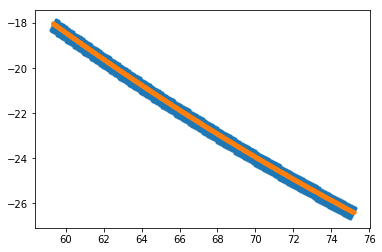

In [39]:
#Read-in validation
ofilen="track.Turranburra.shipp2018.ecsv"
rr=astropy.io.ascii.read(ofilen, format='ecsv')   
#rr["sc"].ra
plt.plot(mwsts["Turranburra"].ra,mwsts["Turranburra"].dec,'.')
plt.plot(rr["sc"].ra.deg,rr["sc"].dec.deg,'.')

Tracks init by pole
====================

In [93]:
tpoles = astropy.io.ascii.read("lib_by_pole.dat",header_start=2)
tpoles

Name,pole_lon,pole_lat,pole_frame,center_lon,center_lat,cent_frame,dlon_deg,dlat,Ro,Rf,Reference
str9,float64,float64,str3,float64,float64,str3,float64,float64,float64,float64,str13
PS1-A,300.856,20.732,equ,160.17,-62.27,gal,5.0,0.45,7.9,7.9,Bernard2016
PS1-B,65.603,32.567,equ,248.41,32.3,gal,10.0,0.45,14.5,14.5,Bernard2016
PS1-C,232.227,33.838,equ,75.12,-32.6,gal,8.0,0.333,17.4,17.4,Bernard2016
PS1-D,49.64,2.467,equ,231.06,32.83,gal,45.0,0.867,22.9,22.9,Bernard2016
PS1-E,42.526,23.987,equ,144.17,58.4,gal,25.0,0.617,12.6,12.6,Bernard2016
ATLAS,77.16,46.92,equ,25.0,-30.0,equ,12.0,0.25,20.0,20.0,Koposov2014
Ophiuchus,184.32,77.25,equ,4.53,31.69,gal,2.5,0.12,9.5,9.5,Bernard2014
Sangarius,178.0,-52.0,gal,149.01,7.847,equ,59.0,0.44,21.0,21.0,Grillmair2017
Scamander,196.0,-41.0,gal,153.52,12.46,equ,66.0,0.22,21.0,21.0,Grillmair2017


In [153]:
gcstep=0.01

tp=tpoles
for i in range(tp["Name"].size)[:]:
    
    #Store pole and center coords, each in its own frame. 
    if "GC" not in tp["pole_frame"][i] and "GC" not in tp["cent_frame"][i]:
        pole_sc = ac.SkyCoord( tp["pole_lon"][i], tp["pole_lat"][i], unit=u.deg, frame=coo_frame[tp["pole_frame"][i]] )
        cent_sc = ac.SkyCoord( tp["center_lon"][i], tp["center_lat"][i], unit=u.deg, frame=coo_frame[tp["cent_frame"][i]] )
                             
        #Generate track from pole. Starting here, do everything in galactic
        azs,lats=gcutils.get_gc_for_pole(pole_sc.galactic.l.deg,pole_sc.galactic.b.deg,degree=True,
                                         center=[cent_sc.galactic.l.deg,cent_sc.galactic.b.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                                                       
        distance = np.ones_like(azs)*tp["Ro"][i]                                                            
        coo = ac.SkyCoord( azs*u.deg, lats*u.deg, frame="galactic", distance = distance*u.kpc )
    else:
        if "GC" not in tp["cent_frame"][i]:
                cent_sc=ac.SkyCoord(tp["center_lon"][i]*u.deg, tp["center_lat"][i]*u.deg, frame=coo_frame[tp["cent_frame"][i]], 
                                    distance=tp["Ro"][i]*u.kpc)
                cent_in_GC=cent_sc.transform_to(ac.Galactocentric)                 
        azs,lats=gcutils.get_gc_for_pole( tp["pole_lon"][i],tp["pole_lat"][i],degree=True,
                                         center=[cent_in_GC.spherical.lon.deg,cent_in_GC.spherical.lat.deg],
                                         dlon=tp["dlon_deg"][i],dlat=0.,step=gcstep)
                                          
        distance=tp["Ro"][i]*np.ones_like(azs)                                                                     
        gc = ac.SkyCoord(lon=azs*u.deg, lat=lats*u.deg, distance=distance*u.kpc, frame=ac.Galactocentric,  representation_type='spherical' )
        #Do it this way, instead of gc.transform_to("galactic"), because extra info in SkyCoord obj gives a RepresentationError when printing ecsv table
        coo = ac.SkyCoord(l=gc.galactic.l, b=gc.galactic.b, distance=gc.galactic.distance, frame='galactic')                     

        
    width = tp["dlat"][i]*np.ones(np.size(coo.l))*u.kpc 
    
    #Track object
    track=pd.DataFrame(dict(l=coo.galactic.l.deg, b=coo.galactic.b.deg, distance=coo.distance.kpc ))
    
    #Print track
    print(tp["Name"][i],np.size(azs))
    ofilen="track.po.{Name}.{Ref}.ecsv".format(Name=tp["Name"][i], Ref=tp["Reference"][i].lower() )
    print("{N} {Name} -> {ofn}".format(N=i, Name=tp["Name"][i], ofn=ofilen))
    #as magic ECSV
    t = astropy.table.QTable([coo, width], names=['sc', 'width'])
    astropy.io.ascii.write(t, format='ecsv', output=ofilen, overwrite='True')   
    #print("printed")

PS1-A 500
0 PS1-A -> track.po.PS1-A.bernard2016.ecsv
PS1-B 1000
1 PS1-B -> track.po.PS1-B.bernard2016.ecsv
PS1-C 800
2 PS1-C -> track.po.PS1-C.bernard2016.ecsv
PS1-D 4500
3 PS1-D -> track.po.PS1-D.bernard2016.ecsv
PS1-E 2500
4 PS1-E -> track.po.PS1-E.bernard2016.ecsv
ATLAS 1200
5 ATLAS -> track.po.ATLAS.koposov2014.ecsv
Ophiuchus 250
6 Ophiuchus -> track.po.Ophiuchus.bernard2014.ecsv
Sangarius 5023
7 Sangarius -> track.po.Sangarius.grillmair2017.ecsv
Scamander 6525
8 Scamander -> track.po.Scamander.grillmair2017.ecsv
Corvus 36000
9 Corvus -> track.po.Corvus.mateu2018.ecsv


In [141]:
t["sc"].b.deg

array([-46.14275137, -46.1483367 , -46.15392221, ..., -46.12599641,
       -46.13158122, -46.13716621])

In [109]:
cc=ac.SkyCoord(60.*u.deg, 9.145*u.deg, distance=1*u.kpc, frame=ac.Galactocentric, representation_type='spherical')

<Longitude 60. deg>

In [110]:
cc.cartesian.x, np.cos(cc.spherical.)

<Quantity 0.49364464 kpc>

Tests
======

In [6]:
track = [[-15.565,   9.145],
             [-14.881,   9.873],
             [-14.537,  10.957],
             [-13.731,  11.824],
             [-13.373,  12.646],
             [-12.198,  14.068],
             [-11.59 ,  15.172],
             [-10.808,  16.029],
             [-10.176,  16.871],
             [ -9.805,  17.428]]
track = np.array(track)
t = ac.SkyCoord(ra=track[:,0]*u.deg,dec=track[:,1]*u.deg,frame='icrs')


In [16]:
azs,lats,azcenter,latcenter=gcutils.get_gc_for_pair(-6.3, -59.7,    3.2,  -59.4,degree=True,step=gcstep,dlat=0.)


In [17]:
mwsts=galstreams.MWStreams(verbose=False)

/Users/cmateu/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


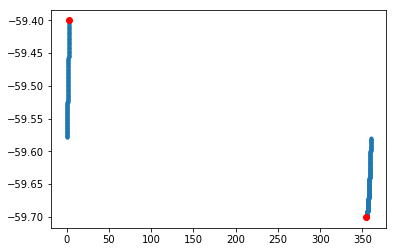

In [24]:
plt.plot(azs,lats,'.')
ii=8
plt.plot(360+tpair["lono"][ii],tpair["lato"][ii],'ro')
plt.plot(tpair["lonf"][ii],tpair["latf"][ii],'ro')
#plt.plot(coo.galactic.l.deg,coo.galactic.b.deg,'x',ms=1)

In [ ]:
plt.plot(coo.ra.deg,coo.dec.deg,'.')
plt.plot(coo.ra.deg,coo.dec.deg,'x')

In [70]:
c = ac.SkyCoord(ra=[-6.3,3.2],dec=[-59.7,-59.4],frame='icrs',unit=u.deg)
c.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    [(353.7, -59.7), (  3.2, -59.4)]>

In [26]:
azs[0],azs[-1],

(354.33, 354.31)

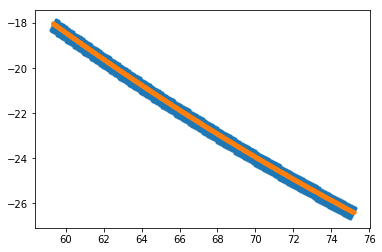

In [37]:
ofilen="track.Turranburra.shipp2018.ecsv"
rr=astropy.io.ascii.read(ofilen, format='ecsv')   
#rr["sc"].ra
plt.plot(mwsts["Turranburra"].ra,mwsts["Turranburra"].dec,'.')
plt.plot(rr["sc"].ra.deg,rr["sc"].dec.deg,'.')

In [76]:
c = ac.SkyCoord(ra=-6.3*u.deg,dec=-59.7*u.deg,distance=10*u.kpc,frame='icrs')


<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in kpc
    (-3.94078643, -3.72526376, -8.1656827)>

In [79]:
c_gc=c.transform_to(ac.Galactocentric)
c_gc.spherical.lon

<Longitude 223.38961565 deg>

In [116]:
c_gc.galactic.l

<Longitude 319.65556147 deg>